In [4]:
import os
from datetime import datetime

# utils
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch_geometric
from torch_geometric.utils import to_dense_batch
from tqdm.notebook import tqdm
import torchinfo

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
pip install torchinfo


Note: you may need to restart the kernel to use updated packages.


In [6]:
print(torch.__version__)
print(torch_geometric.__version__)

2.2.2
2.6.1


## Utils

In [7]:
from utils import model_size
from utils.losses import chamfer_dist_repulsion, density_chamfer_dist, chamfer_distance

from torch_geometric.loader import DataLoader as PyGLoader
from utils.data import PairData, PCDDataset, load_h5_data
from utils.viz import viz_many, viz_many_mpl

### Configs

In [9]:
from omegaconf import OmegaConf

In [10]:
data_path = "/Users/ivantothrohonyi/PU-GCN-pytorch/data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5"

exp_conf = OmegaConf.load(os.path.join("conf", "config.yaml"))
model_config = exp_conf.model_config
train_config = exp_conf.train_config
data_config = exp_conf.data_config

In [11]:
print(OmegaConf.to_yaml(exp_conf))

name: pugcn-baseline
model_config:
  r: 4
  k: 16
  dilations:
  - 1
  - 2
  - 4
  n_idgcn_blocks: 3
  channels: 64
  n_dgcn_blocks: 3
  use_bottleneck: true
  use_pooling: true
  use_residual: true
  conv: edge
  pool_type: mean
  dynamic: false
  use_refiner: false
  upsampler: nodeshuffle
  hierarchical: false
train_config:
  batch_size: 64
  epochs: 10
  optimizer: adam
  lr: 0.001
  betas:
  - 0.9
  - 0.999
  save_every: 5
  augment: true
  loss_fn: cd
  k_loss: 4
data_config:
  path: ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
  num_point: 256
  skip_rate: 1
  use_randominput: true
  rng_seed: 42



# Data

In [13]:
from utils.data import PCDDataset

# Path to your new dataset
data_path = '/Users/ivantothrohonyi/PU-GCN-pytorch/pu1k_uniform256_uniform1024_from_meshes.h5'

# Load the dataset
dataset = PCDDataset.from_h5(
    data_path,
    num_point=256,        # this matches your input cloud size
    up_ratio=4,           # this matches 256 → 1024 (adjust if needed)
    skip_rate=1,          # or use data_config.skip_rate if defined
    seed=42               # or use data_config.rng_seed if defined
)


h5_filename :  /Users/ivantothrohonyi/PU-GCN-pytorch/pu1k_uniform256_uniform1024_from_meshes.h5
Do not randominput, input h5 file is: /Users/ivantothrohonyi/PU-GCN-pytorch/pu1k_uniform256_uniform1024_from_meshes.h5
Normalization the data
total 1000 samples


In [28]:
data_config.rng_seed

42

In [14]:
print(dir(dataset))


['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_is_protocol', 'augment', 'data', 'data_radius', 'from_h5', 'ground_truth', 'rng']


In [15]:
#code to reduce sample size

from torch.utils.data import Subset

subset_size = len(dataset) // 10
indices = list(range(subset_size))  
dataset = Subset(dataset, indices)

In [16]:
print(dataset)

In [80]:
# Check one sample
data = dataset[42]
data_cloud, gt_cloud = data.pos_s, data.pos_t
gt_cloud

tensor([[-0.0229,  0.0478,  0.9552],
        [ 0.1127, -0.1518,  0.7979],
        [-0.1125,  0.1484,  0.5378],
        ...,
        [ 0.0747, -0.1561,  0.3016],
        [ 0.1653, -0.1561, -0.0087],
        [ 0.0556,  0.1653, -0.1317]])

In [81]:
idx = torch.randperm(gt_cloud.shape[0])[:data_cloud.shape[0]]
data_cloud = gt_cloud[idx]

In [82]:
from torch_cluster import fps


In [83]:
ratio = data_cloud.shape[0] / gt_cloud.shape[0]
fps_idx = fps(gt_cloud, batch=torch.zeros(gt_cloud.shape[0], dtype=torch.long), ratio=ratio)
data_cloud = gt_cloud[fps_idx]

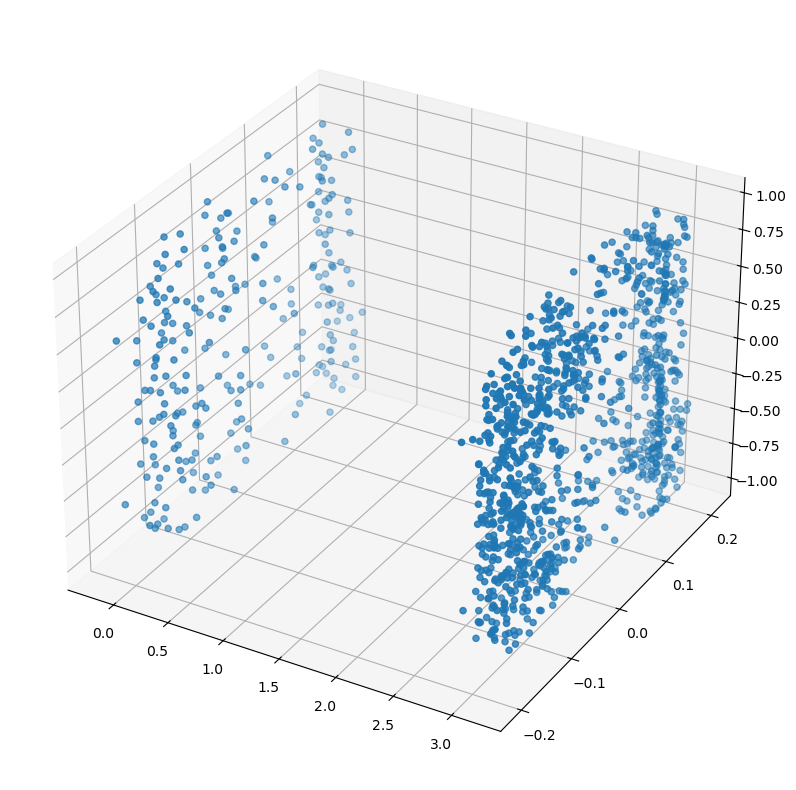

In [84]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
viz_many_mpl([data_cloud, gt_cloud], ax=ax)

In [29]:
import numpy as np
import torch

def quasi_poisson_disk_sample(pc: torch.Tensor, num_samples: int, min_dist=0.03) -> torch.Tensor:
    """
    Approximate Poisson disk sampling from an existing point cloud (quasi-Poisson).
    Greedily selects points at least `min_dist` apart.
    Args:
        pc: (N, 3) input point cloud
        num_samples: how many points to sample
        min_dist: minimum allowed distance between any two sampled points
    Returns:
        (num_samples, 3) sampled points
    """
    pc_np = pc.cpu().numpy()
    selected = []
    remaining = np.arange(len(pc_np))
    np.random.shuffle(remaining)

    while len(selected) < num_samples and remaining.size > 0:
        idx = remaining[0]
        selected.append(idx)
        if len(selected) >= num_samples:
            break
        dists = np.linalg.norm(pc_np[remaining] - pc_np[idx], axis=1)
        remaining = remaining[dists >= min_dist]

    # If we undershoot, randomly add more
    if len(selected) < num_samples:
        filler = np.setdiff1d(np.arange(len(pc_np)), selected)
        filler = np.random.choice(filler, size=num_samples - len(selected), replace=False)
        selected.extend(filler)

    return torch.tensor(pc_np[selected], dtype=torch.float32)


In [30]:
def voxel_grid_sample(pc: torch.Tensor, voxel_size=0.05, num_samples=None) -> torch.Tensor:
    """
    Simple voxel grid sampling: retain at most one point per voxel.
    Args:
        pc: (N, 3) input point cloud
        voxel_size: edge length of each voxel
        num_samples: optionally truncate or pad result to this number
    Returns:
        (≤num_samples, 3) sampled points
    """
    pc_np = pc.cpu().numpy()
    coords = np.floor(pc_np / voxel_size).astype(np.int32)
    _, idx = np.unique(coords, axis=0, return_index=True)
    sampled = pc_np[idx]

    # Pad or truncate if needed
    if num_samples is not None:
        if len(sampled) > num_samples:
            sampled = sampled[:num_samples]
        elif len(sampled) < num_samples:
            extra = pc_np[np.random.choice(len(pc_np), size=num_samples - len(sampled), replace=False)]
            sampled = np.concatenate([sampled, extra], axis=0)

    return torch.tensor(sampled, dtype=torch.float32)


In [31]:
data = dataset[1]
gt_cloud = data.pos_t
data_cloud = data.pos_s

# Try Quasi-Poisson:
poisson_cloud = quasi_poisson_disk_sample(gt_cloud, num_samples=data_cloud.shape[0])

# Try Voxel Grid:
voxel_cloud = voxel_grid_sample(gt_cloud, voxel_size=0.05, num_samples=data_cloud.shape[0])

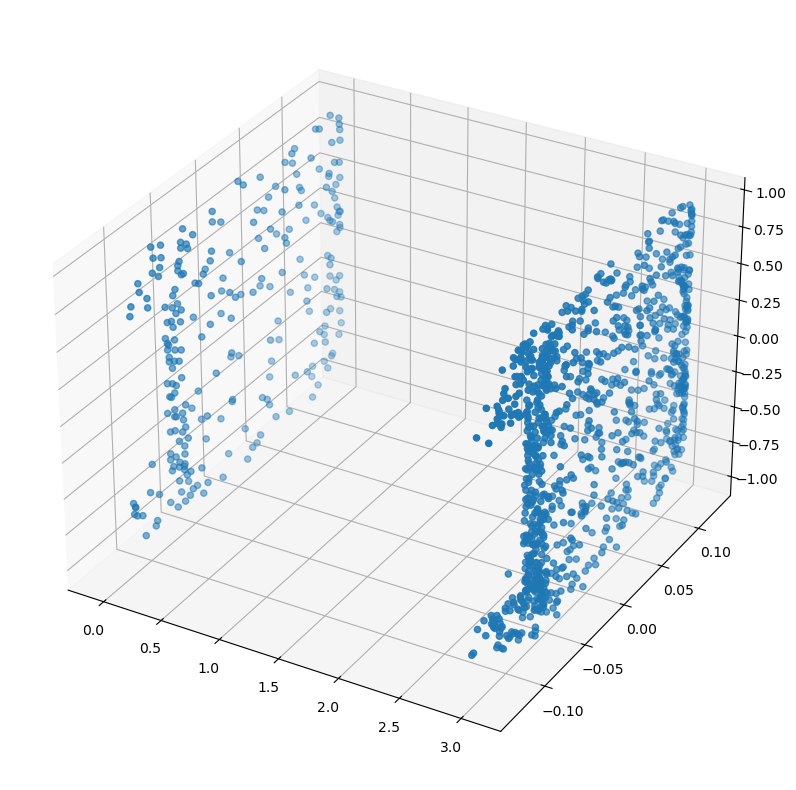

In [32]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
viz_many_mpl([poisson_cloud, gt_cloud], ax=ax)

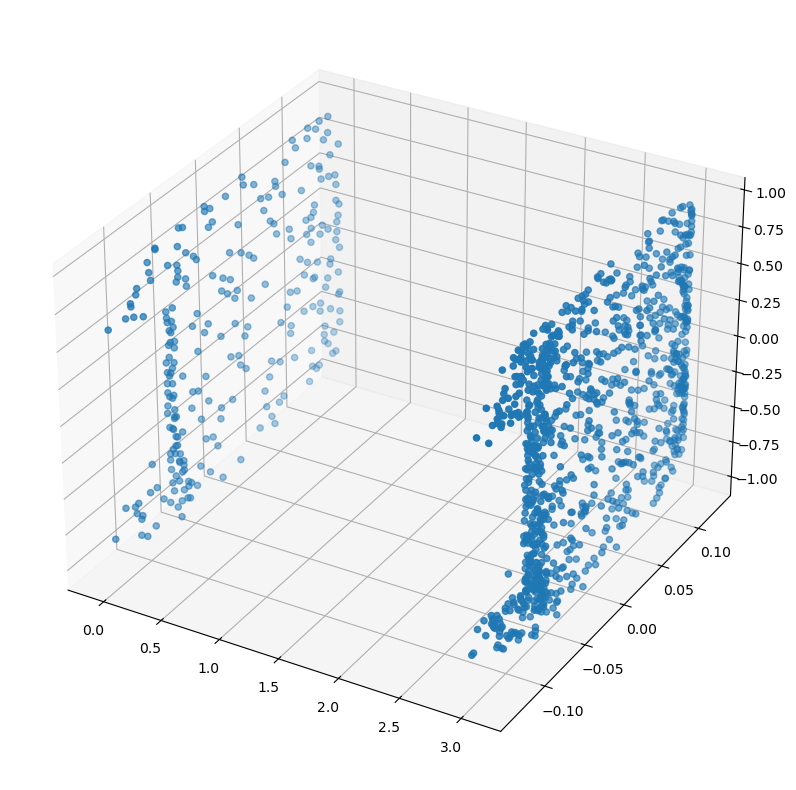

In [33]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
viz_many_mpl([voxel_cloud, gt_cloud], ax=ax)

ERROR: unknown command "trimesh"
Note: you may need to restart the kernel to use updated packages.


In [37]:
pip install trimesh


Note: you may need to restart the kernel to use updated packages.


In [56]:
import os
import numpy as np
import torch
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define base path
base_path = '/Users/ivantothrohonyi/PU-GCN-pytorch/data/PU1K/test/'

# Define specific paths
input_256_dir = os.path.join(base_path, 'input_256/input_256')
gt_1024_dir = os.path.join(base_path, 'input_256/gt_1024')
original_meshes_dir = os.path.join(base_path, 'original_meshes')

# Helper function to load .xyz files
def load_xyz(file_path):
    """Load point cloud data from an .xyz file."""
    return np.loadtxt(file_path)

# Helper function to visualize point clouds
def visualize_point_cloud(points, title="Point Cloud"):
    """Visualize a 3D point cloud."""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)
    ax.set_title(title)
    plt.show()

# Helper function to visualize meshes
def visualize_mesh(mesh, title="Mesh"):
    """Visualize a 3D mesh."""
    mesh.show()


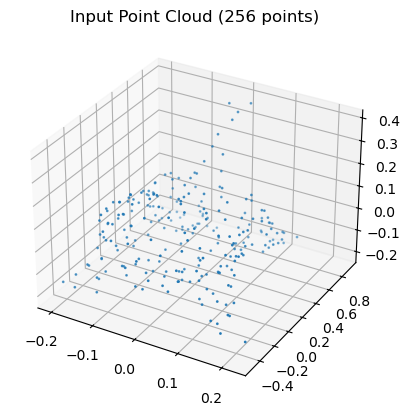

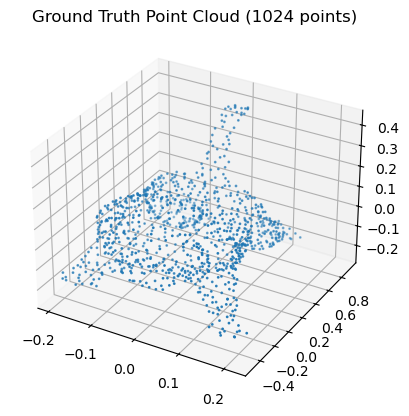

In [60]:

# Example: Process a single sample
sample_name = '13770_Tiger_V1'  # Replace with the actual sample name without extension

# Load input point cloud (256 points)
input_pc_path = os.path.join(input_256_dir, f'{sample_name}.xyz')
input_pc = load_xyz(input_pc_path)

# Load ground truth point cloud (1024 points)
gt_pc_path = os.path.join(gt_1024_dir, f'{sample_name}.xyz')
gt_pc = load_xyz(gt_pc_path)

# Load original mesh
mesh_path = os.path.join(original_meshes_dir, f'{sample_name}.off')
mesh = trimesh.load(mesh_path)

# Visualize the input point cloud
visualize_point_cloud(input_pc, title="Input Point Cloud (256 points)")

# Visualize the ground truth point cloud
visualize_point_cloud(gt_pc, title="Ground Truth Point Cloud (1024 points)")

# Visualize the original mesh
visualize_mesh(mesh, title="Original Mesh")

# Convert point clouds to PyTorch tensors
input_pc_tensor = torch.tensor(input_pc, dtype=torch.float32)
gt_pc_tensor = torch.tensor(gt_pc, dtype=torch.float32)

# Now, input_pc_tensor and gt_pc_tensor are ready for further processing


In [57]:
visualize_mesh(mesh, title="Original Mesh")


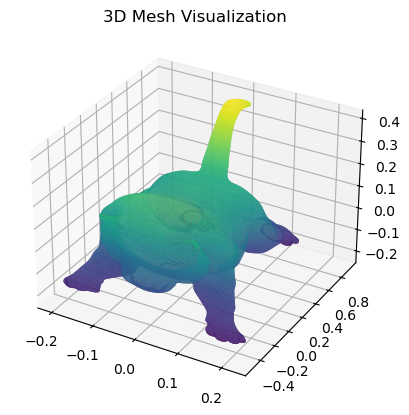

In [61]:
def visualize_mesh_with_matplotlib(mesh):
    """Visualize a 3D mesh using matplotlib."""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2], triangles=mesh.faces, cmap='viridis')
    ax.set_title("3D Mesh Visualization")
    plt.show()

# Usage:
visualize_mesh_with_matplotlib(mesh)

In [62]:
# Function to check if a point cloud is a subset of the mesh
def is_subset_of_mesh(point_cloud, mesh, tolerance=1e-4):
    # Compute signed distances from the point cloud to the mesh
    signed_distances = trimesh.proximity.signed_distance(mesh, point_cloud)
    # Check if all points are inside or on the surface of the mesh within the tolerance
    return np.all(signed_distances >= -tolerance)

# Check if the 256-point input point cloud is a subset of the mesh
input_is_subset = is_subset_of_mesh(input_pc, mesh)
print(f"256-point input point cloud is a subset of the mesh: {input_is_subset}")

# Check if the 1024-point ground truth point cloud is a subset of the mesh
gt_is_subset = is_subset_of_mesh(gt_pc, mesh)
print(f"1024-point ground truth point cloud is a subset of the mesh: {gt_is_subset}")


256-point input point cloud is a subset of the mesh: True
1024-point ground truth point cloud is a subset of the mesh: True


In [63]:
import numpy as np

def is_subset(input_pc, gt_pc):
    """
    Check if all points in input_pc are present in gt_pc.

    Parameters:
    - input_pc: NumPy array of shape (N, 3) representing the input point cloud.
    - gt_pc: NumPy array of shape (M, 3) representing the ground truth point cloud.

    Returns:
    - True if input_pc is a subset of gt_pc, False otherwise.
    """
    # Convert both point clouds to sets of tuples for comparison
    input_set = set(map(tuple, input_pc))
    gt_set = set(map(tuple, gt_pc))

    # Check if input_set is a subset of gt_set
    return input_set.issubset(gt_set)

# Example usage:
# input_pc and gt_pc should be loaded or defined as NumPy arrays of shape (N, 3) and (M, 3) respectively.
if is_subset(input_pc, gt_pc):
    print("The 256-point input point cloud is a subset of the 1024-point ground truth point cloud.")
else:
    print("The 256-point input point cloud is NOT a subset of the 1024-point ground truth point cloud.")


The 256-point input point cloud is NOT a subset of the 1024-point ground truth point cloud.


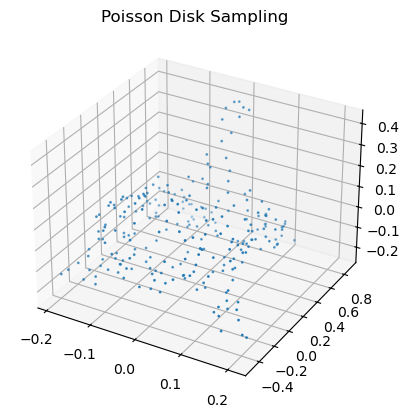

In [66]:
  # Sample points using Poisson Disk Sampling
  poisson_sampled_points, _ = trimesh.sample.sample_surface_even(mesh, count=256)

  # Visualize the sampled points
  visualize_point_cloud(poisson_sampled_points, title="Poisson Disk Sampling")


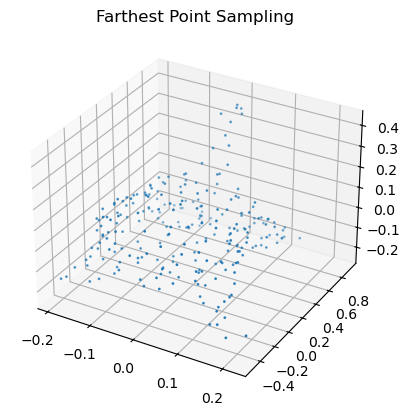

In [67]:
  import numpy as np

  def farthest_point_sampling(points, n_samples):
      """
      Perform Farthest Point Sampling (FPS) on a point cloud.

      Parameters:
      - points: NumPy array of shape (N, 3) representing the input point cloud.
      - n_samples: Integer, number of points to sample.

      Returns:
      - NumPy array of shape (n_samples, 3) representing the sampled points.
      """
      N = points.shape[0]
      sampled_indices = np.zeros(n_samples, dtype=int)
      distances = np.full(N, np.inf)

      # Initialize by selecting a random point
      sampled_indices[0] = np.random.randint(N)
      selected_point = points[sampled_indices[0], :]

      for i in range(1, n_samples):
          # Update distances to the selected point
          dist_to_selected = np.linalg.norm(points - selected_point, axis=1)
          distances = np.minimum(distances, dist_to_selected)

          # Select the point farthest from the existing sampled points
          sampled_indices[i] = np.argmax(distances)
          selected_point = points[sampled_indices[i], :]

      return points[sampled_indices, :]

  # Sample an initial dense point cloud from the mesh
  dense_sampled_points, _ = trimesh.sample.sample_surface(mesh, count=1024)

  # Perform FPS to downsample to 256 points
  fps_sampled_points = farthest_point_sampling(dense_sampled_points, n_samples=256)

  # Visualize the sampled points
  visualize_point_cloud(fps_sampled_points, title="Farthest Point Sampling")


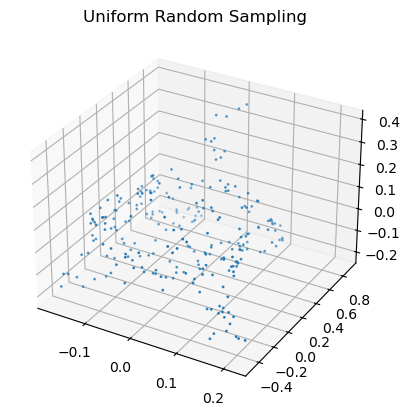

In [68]:
  # Sample points using Uniform Random Sampling
  uniform_random_sampled_points, _ = trimesh.sample.sample_surface(mesh, count=256)

  # Visualize the sampled points
  visualize_point_cloud(uniform_random_sampled_points, title="Uniform Random Sampling")


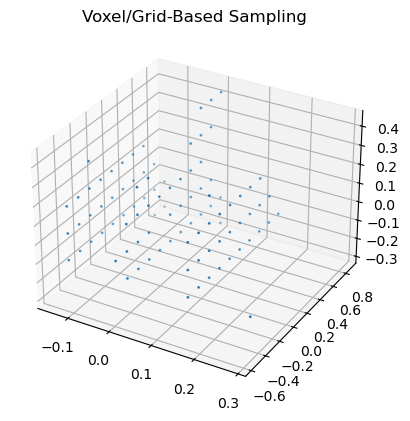

In [69]:
  import numpy as np

  # Define the voxel size
  voxel_size = mesh.extents.max() / 10  # Adjust the divisor to control the number of voxels

  # Voxelize the mesh
  voxel_grid = mesh.voxelized(pitch=voxel_size)

  # Extract the voxel centers
  voxel_centers = voxel_grid.points

  # If there are more voxel centers than needed, randomly sample 256 of them
  if voxel_centers.shape[0] > 256:
      indices = np.random.choice(voxel_centers.shape[0], 256, replace=False)
      voxel_sampled_points = voxel_centers[indices]
  else:
      voxel_sampled_points = voxel_centers

  # Visualize the sampled points
  visualize_point_cloud(voxel_sampled_points, title="Voxel/Grid-Based Sampling")


In [70]:
import os
import trimesh


In [71]:
root_dir = '/Users/ivantothrohonyi/PU-GCN-pytorch/data/PU1K_raw_meshes/ShapeNetCore.v2.subsample'


In [50]:
import os
import trimesh
import numpy as np
import h5py
from tqdm import tqdm

# === CONFIGURATION ===
root_dir = '/Users/ivantothrohonyi/PU-GCN-pytorch/data/PU1K_raw_meshes/ShapeNetCore.v2.subsample'
output_h5_path = '/Users/ivantothrohonyi/PU-GCN-pytorch/pu1k_uniform256_uniform1024_from_meshes.h5'
input_size = 256
gt_size = 1024

# === SAMPLING FUNCTION ===
def uniform_sample(mesh, n):
    """
    Uniformly sample `n` points from a mesh surface.
    """
    points, _ = trimesh.sample.sample_surface(mesh, n)
    return points

# === DATA PROCESSING ===
input_point_clouds = []
gt_point_clouds = []

# Traverse all subdirectories and .off files
mesh_files = []
for subdir, _, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.off'):
            mesh_files.append(os.path.join(subdir, file))

print(f"Found {len(mesh_files)} mesh files.")

# Process each mesh
for mesh_path in tqdm(mesh_files, desc="Processing meshes"):
    try:
        mesh = trimesh.load(mesh_path, force='mesh')
        input_pc = uniform_sample(mesh, input_size)
        gt_pc = uniform_sample(mesh, gt_size)
        
        input_point_clouds.append(input_pc.astype(np.float32))
        gt_point_clouds.append(gt_pc.astype(np.float32))
    except Exception as e:
        print(f"[Error] {mesh_path}: {e}")

# Convert lists to arrays
input_array = np.array(input_point_clouds, dtype=np.float32)  # shape (N, 256, 3)
gt_array = np.array(gt_point_clouds, dtype=np.float32)        # shape (N, 1024, 3)

# === SAVE TO HDF5 ===
with h5py.File(output_h5_path, 'w') as f:
    f.create_dataset('poisson_256', data=input_array)     # Compatible with PU-GCN
    f.create_dataset('poisson_1024', data=gt_array)

print(f"✅ Saved {len(input_array)} samples to {output_h5_path}")


Found 1000 mesh files.


Processing meshes: 100%|████████████████████| 1000/1000 [01:06<00:00, 15.11it/s]


✅ Saved 1000 samples to /Users/ivantothrohonyi/PU-GCN-pytorch/pu1k_uniform256_uniform1024_from_meshes.h5


In [291]:
np. __version__

'1.26.4'

In [74]:
from utils.data import PCDDataset

# Path to your new dataset
data_path = '/Users/ivantothrohonyi/PU-GCN-pytorch/pu1k_uniform256_uniform1024_from_meshes.h5'

# Load the dataset
dataset = PCDDataset.from_h5(
    data_path,
    num_point=256,        # this matches your input cloud size
    up_ratio=4,           # this matches 256 → 1024 (adjust if needed)
    skip_rate=1,          # or use data_config.skip_rate if defined
    seed=42               # or use data_config.rng_seed if defined
)

h5_filename :  /Users/ivantothrohonyi/PU-GCN-pytorch/pu1k_uniform256_uniform1024_from_meshes.h5
Do not randominput, input h5 file is: /Users/ivantothrohonyi/PU-GCN-pytorch/pu1k_uniform256_uniform1024_from_meshes.h5
Normalization the data
total 1000 samples
